<a href="https://colab.research.google.com/github/KyuhyoJeon/SiamBYOL/blob/main/SiamBYOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ### Google drive mount ###
# from google.colab import drive 
# drive.mount('/content/gdrive/')
# ### ------------------------------------------ ###

Mounted at /content/gdrive/


In [16]:
### Arguments define ###
import easydict
import os
from datetime import datetime

args = easydict.EasyDict({
    'image_size':32, # original = 224
    'learning_rate':0.2, # original lr = 0.2, others = 0.3 or 3e-4
    'momentum':0, 
    'weight_decay':1.5e-6, 
    'batch_size':4096, 
    'num_epochs':1000, 
    'warmup_epochs':10, 
    'resnet_version':'resnet50', # original = resnet50
    'optim':'sgd', 
    'checkpoint_epochs':10, 
    # ********************MUST CHECK********************** #
    'dataset_dir':'./datasets', # dataset directory
    'ckpt_dir':'/content/gdrive/MyDrive/Colab Notebooks/siambyol/ckpt',   # Network checkpoint directory
    'num_workers':8, 
    'nodes':1, 
    'gpus':1, 
    'nr':0, 
    'device':'cuda', 
    'eval':True, 
    'eval_epochs':30, 
    # ********************MUST CHECK********************** #
    'dryrun':True, # check line 47~53
    'debug':True, # check line 56~62
    'current_epochs':0, 
    'data_load_check':False
})

# ********************MUST CHECK********************** #
# dryrun setting
if args.dryrun:
  args.image_size=32
  args.num_epochs = 100
  args.batch_size = 256
  args.num_workers = 4
  args.resnet_version = 'resnet18'

# ********************MUST CHECK********************** #
# debug setting
if args.debug:
  args.image_size=32
  args.num_epochs = 1
  args.batch_size = 2
  args.num_workers = 0
  args.debug_subset_size = 8
  args.resnet_version = 'resnet18'
  args.eval = False
  args.data_load_check = True
  

# make check point directory ex: "ckpt_dir/resnet18/lars/021805"
tmp_dir = os.path.join(args.ckpt_dir, f"{args.resnet_version}", f"{args.optim}", f"{datetime.now().strftime('%m%d%H')}")
if args.debug:
  tmp_dir = os.path.join(args.ckpt_dir, f"{args.resnet_version}", f"{args.optim}", f"debug")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)
### ------------------------------------------ ###

In [17]:
### Image augmentation define
import torch
import torchvision
from torchvision import datasets, transforms

class simclr_transform:
  # augmentations: 
  # random patch, 224 resize, random hrizontal flip, color distortion, 
  # random swquence brightness, contrast, saturation, hue adjustment, 
  # and optional gray scale conversion, Gaussian blur, solarization
  imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]
  def __init__(self, size, mean_std=imagenet_mean_std, s=1.0):
    self.transform = transforms.Compose(
        [
        transforms.RandomResizedCrop(size=size), ###
        transforms.RandomHorizontalFlip(), 
        transforms.RandomApply(
            [transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=size//20*2+1, sigma=(0.1, 2.0))], p=0.5), 
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
        ]
    )
  def __call__(self, x):
    x1 = self.transform(x)
    x2 = self.transform(x)
    return x1, x2

from PIL import Image

class Transform_single():
  imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]
  def __init__(self, size, train, normalize=imagenet_mean_std):
    if train == True:
      self.transform = transforms.Compose(
          [
           transforms.RandomResizedCrop(size, scale=(0.08, 1.0), 
                                        ratio=(3.0/4.0,4.0/3.0), 
                                        interpolation=Image.BICUBIC
                                        ),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)
          ]
      )
    else:
      self.transform = transforms.Compose(
          [
           transforms.Resize(int(size*(8/7)), 
                             interpolation=Image.BICUBIC
                             ), # 224 -> 256 
           transforms.CenterCrop(size),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)
          ]
      )

  def __call__(self, x):
    return self.transform(x)
### ------------------------------------------ ###

In [19]:
### dataset load ###
cifar_train = datasets.CIFAR10(
    root=args.dataset_dir, 
    train=True, 
    transform=simclr_transform(args.image_size), 
    download=True
)

if args.debug:
  cifar_train = torch.utils.data.Subset(cifar_train, range(0, args.debug_subset_size))
  cifar_train.classes = cifar_train.dataset.classes
  cifar_train.targets = cifar_train.dataset.targets

train_loader = torch.utils.data.DataLoader(
    cifar_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=args.num_workers, 
    drop_last=True, 
    pin_memory=True
)
### ------------------------------------------ ###

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


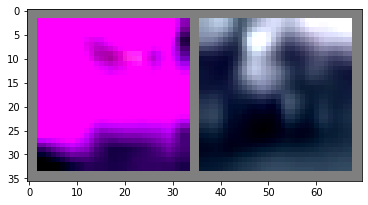

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


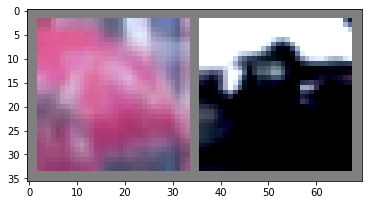

automobile truck


In [20]:
### dataset load check ###
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

if args.data_load_check:
  dataiter = iter(train_loader)
  (images1, images2), labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images1))
  imshow(torchvision.utils.make_grid(images2))
  print(' '.join('%5s' % train_loader.dataset.classes[labels[j]] for j in range(len(labels))))
  ### ------------------------------------------ ###

In [21]:
### ResNet18 for CIFAR10 define ###
import torch
import torch.nn as nn
import os
# https://raw.githubusercontent.com/huyvnphan/PyTorch_CIFAR10/master/cifar10_models/resnet.py
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError('BasicBlock only supports groups=1 and base_width=64')
    if dilation > 1:
      raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
    # Both self.conv1 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                base_width=64, dilation=1, norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
        norm_layer = nn.BatchNorm2d
    width = int(planes * (base_width / 64.)) * groups
    # Both self.conv2 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv1x1(inplanes, width)
    self.bn1 = norm_layer(width)
    self.conv2 = conv3x3(width, width, stride, groups, dilation)
    self.bn2 = norm_layer(width)
    self.conv3 = conv1x1(width, planes * self.expansion)
    self.bn3 = norm_layer(planes * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = self.relu(out)

      return out


class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                groups=1, width_per_group=64, replace_stride_with_dilation=None,
                norm_layer=None):
    super(ResNet, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = 64
    self.dilation = 1
    if replace_stride_with_dilation is None:
      # each element in the tuple indicates if we should replace
      # the 2x2 stride with a dilated convolution instead
      replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
      raise ValueError("replace_stride_with_dilation should be None "
                        "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    self.groups = groups
    self.base_width = width_per_group
    
    ## CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
    ## END
    
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                    dilate=replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                    dilate=replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                    dilate=replace_stride_with_dilation[2])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Zero-initialize the last BN in each residual branch,
    # so that the residual branch starts with zeros, and each residual block behaves like an identity.
    # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, Bottleneck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
        self.dilation *= stride
        stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            conv1x1(self.inplanes, planes * block.expansion, stride),
            norm_layer(planes * block.expansion),
        )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation, norm_layer))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    # x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc(x)

    return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
  model = ResNet(block, layers, **kwargs)
  if pretrained:
      script_dir = os.path.dirname(__file__)
      state_dict = torch.load(script_dir + '/state_dicts/'+arch+'.pt', map_location=device)
      model.load_state_dict(state_dict)
  return model


def resnet18(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNet-18 model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress, device,
                  **kwargs)


def resnet34(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNet-34 model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress, device,
                  **kwargs)


def resnet50(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNet-50 model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, device,
                  **kwargs)


def resnet101(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNet-101 model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress, device,
                  **kwargs)


def resnet152(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNet-152 model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress, device,
                  **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNeXt-50 32x4d model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  kwargs['groups'] = 32
  kwargs['width_per_group'] = 4
  return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                  pretrained, progress, device, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, device='cpu', **kwargs):
  """Constructs a ResNeXt-101 32x8d model.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
      progress (bool): If True, displays a progress bar of the download to stderr
  """
  kwargs['groups'] = 32
  kwargs['width_per_group'] = 8
  return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                  pretrained, progress, device, **kwargs)

### ------------------------------------------ ###

In [22]:
### resnet call ###
import copy
import torch.nn as nn
from torchvision import models

if args.resnet_version is not None:
  resnet = eval(f'{args.resnet_version}()')
  siamresnet = copy.deepcopy(resnet)
  
  resnet.output_dim = resnet.fc.in_features
  resnet.fc = nn.Identity()
  siamresnet.output_dim = siamresnet.fc.in_features
  siamresnet.fc = nn.Identity()
else:
  raise NotImplementedError("Backbone is not implemented!")
### ------------------------------------------ ###

In [37]:
### siambyol network define ###
import math
from torch.nn import functional

hidden_size=4096
projection_size=256

class MLP(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_size), 
        nn.BatchNorm1d(hidden_size, momentum=1-0.9, eps=1e-5), 
        nn.ReLU(inplace=True), 
        nn.Linear(hidden_size, projection_size)
    )
  def forward(self, x):
    return self.net(x)

class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()

    self.backbone=backbone
    self.projector = MLP(backbone.output_dim)
    self.online_encoder = nn.Sequential(
        self.backbone, 
        self.projector,
    )
    self.predictor = MLP(projection_size)
    self.target_encoder = copy.deepcopy(self.online_encoder)

  def set_online(self, model):
    del self.online_encoder
    self.online_encoder = copy.deepcopy(model)

  def target_ema(self, k, K, base_tau=0.996):
    return 1-(1-base_tau)*(math.cos(math.pi*k/K)+1)/2

  def update_moving_average(self, global_step, max_steps):
    tau = self.target_ema(global_step, max_steps)
    for online, target in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
      target.data = tau*target.data + (1-tau)*online.data
  
  def loss_function(self, p, z):
    p=functional.normalize(p, dim=-1, p=2)
    z=functional.normalize(z, dim=-1, p=2)
    return 2 - 2*(p*z).sum(dim=-1)

  def forward(self, x1, x2):
    z1_online, z2_online = self.online_encoder(x1), self.online_encoder(x2)
    p1_online, p2_online = self.predictor(z1_online), self.predictor(z2_online)
    with torch.no_grad():
      z1_target, z2_target = self.target_encoder(x1), self.target_encoder(x2)
    
    loss1, loss2 = self.loss_function(p1_online, z2_target.detach()), self.loss_function(p2_online, z1_target.detach())

    loss = loss1+loss2
    return loss.mean()

class SiamBYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()

    self.backbone=backbone
    self.projector = MLP(backbone.output_dim)
    self.online_encoder = nn.Sequential(
        self.backbone, 
        self.projector,
    )
    self.predictor = MLP(projection_size)
    self.target_encoder = None
  
  def set_target(self, model):
    del self.target_encoder
    self.target_encoder = copy.deepcopy(model)
  
  def loss_function(self, p, z):
    p=functional.normalize(p, dim=-1, p=2)
    z=functional.normalize(z, dim=-1, p=2)
    return 2 - 2*(p*z).sum(dim=-1)

  def target_ema(self, k, K, base_tau=0.996):
    return 1-(1-base_tau)*(math.cos(math.pi*k/K)+1)/2

  def update_moving_average(self, global_step, max_steps):
    tau = self.target_ema(global_step, max_steps)
    for online, target in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
      target.data = tau*target.data + (1-tau)*online.data

  def forward(self, x1, x2, target):
    z1_online, z2_online = self.online_encoder(x1), self.online_encoder(x2)
    p1_online, p2_online = self.predictor(z1_online), self.predictor(z2_online)

    with torch.no_grad():
      self.set_target(target)
      z1_target, z2_target = self.target_encoder(x1), self.target_encoder(x2)
    
    loss1, loss2 = self.loss_function(p1_online, z2_target.detach()), self.loss_function(p2_online, z1_target.detach())

    loss = loss1+loss2
    return loss.mean()
### ------------------------------------------ ###

In [38]:
### byol network call ###
byol = BYOL(resnet)

# model load, check 'pre model path' to load pre model
if args.current_epochs != 0:
  pre_model = torch.load('')
  msg = byol.load_state_dict(pre_model['state_dict'])
  print(msg)

byol = byol.to(args.device)
byol = torch.nn.DataParallel(byol)

siambyol = SiamBYOL(siamresnet)

# model load, check 'pre model path' to load pre model
if args.current_epochs != 0:
  pre_model = torch.load('')
  msg = siambyol.load_state_dict(pre_model['state_dict'])
  print(msg)

siambyol = siambyol.to(args.device)
siambyol = torch.nn.DataParallel(siambyol)
### ------------------------------------------ ###

In [39]:
### optimizer call ###
from torch.optim import SGD

predictor_prefix = ('module.predictor', 'predictor')
byol_parameters = [{
    'name': 'base',
    'params': [param for name, param in byol.named_parameters() if not name.startswith(predictor_prefix)],
    'lr': args.learning_rate
},{
    'name': 'predictor',
    'params': [param for name, param in byol.named_parameters() if name.startswith(predictor_prefix)],
    'lr': args.learning_rate
}]
siambyol_parameters = [{
    'name': 'base',
    'params': [param for name, param in siambyol.named_parameters() if not name.startswith(predictor_prefix)],
    'lr': args.learning_rate
},{
    'name': 'predictor',
    'params': [param for name, param in siambyol.named_parameters() if name.startswith(predictor_prefix)],
    'lr': args.learning_rate
}]

byol_optimizer = SGD(byol_parameters, lr=args.learning_rate*args.batch_size/256, momentum=0.9)
siambyol_optimizer = SGD(siambyol_parameters, lr=args.learning_rate*args.batch_size/256, momentum=0.9)
### ------------------------------------------ ###

In [40]:
### learning rate scheduler define ###
import numpy as np

class LR_Scheduler(object):
  def __init__(self, optimizer, warmup_epochs, warmup_lr, num_epochs, base_lr, final_lr, iter_per_epoch, constant_predictor_lr=False):
    self.base_lr = base_lr
    self.constant_predictor_lr = constant_predictor_lr
    warmup_iter = iter_per_epoch * warmup_epochs
    warmup_lr_schedule = np.linspace(warmup_lr, base_lr, warmup_iter)
    decay_iter = iter_per_epoch * (num_epochs - warmup_epochs)
    cosine_lr_schedule = final_lr+0.5*(base_lr-final_lr)*(1+np.cos(np.pi*np.arange(decay_iter)/decay_iter))
    
    self.lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
    self.optimizer = optimizer
    self.iter = 0
    self.current_lr = 0
  def step(self):
    for param_group in self.optimizer.param_groups:

      if self.constant_predictor_lr and param_group['name'] == 'predictor':
        param_group['lr'] = self.base_lr
      else:
        lr = param_group['lr'] = self.lr_schedule[self.iter]
    
    self.iter += 1
    self.current_lr = lr
    return lr
  def get_lr(self):
    return self.current_lr
### ------------------------------------------ ###

In [41]:
### lr_scheduler define ###
byol_lr_scheduler = LR_Scheduler(byol_optimizer, args.warmup_epochs, 0, args.num_epochs, args.learning_rate*args.batch_size/256, 0, len(train_loader), constant_predictor_lr=True)
siambyol_lr_scheduler = LR_Scheduler(siambyol_optimizer, args.warmup_epochs, 0, args.num_epochs, args.learning_rate*args.batch_size/256, 0, len(train_loader), constant_predictor_lr=True)
### ------------------------------------------ ###

In [42]:
### Training ###
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
from datetime import datetime
from tqdm import tqdm
import os

writer = SummaryWriter()

global_step = 0
for epoch in tqdm(range(args.current_epochs, args.num_epochs), desc=f'Training'):
  metrics = defaultdict(list)
  
  for step, ((x1, x2), labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{args.num_epochs}')):
    x1, x2 = x1.cuda(non_blocking=True), x2.cuda(non_blocking=True)

    byol_loss = byol(x1, x2)
    byol_optimizer.zero_grad()
    byol_loss.backward()
    byol_optimizer.step()
    byol_lr_scheduler.step() # defined scheduler
    byol.module.update_moving_average(step+1, len(train_loader))

    siambyol_loss = siambyol(x1, x2, byol.module.online_encoder)
    siambyol_optimizer.zero_grad()
    siambyol_loss.backward()
    siambyol_optimizer.step()
    siambyol_lr_scheduler.step()
    siambyol.module.update_moving_average(step+1, len(train_loader))

    byol.module.set_online(siambyol.module.target_encoder)
    
    writer.add_scalar("Loss/train_step", siambyol_loss, global_step)
    metrics["Loss/train"].append(siambyol_loss.item())
    global_step += 1
  
  for k, v in metrics.items():
    writer.add_scalar(k, np.array(v).mean(), epoch+1)

  if (epoch+1)%args.checkpoint_epochs == 0:
    byol_ckpt_path = os.path.join(tmp_dir, f"byol_{args.optim}_{epoch+1}.pt")
    print(f'Saving model at epoch {epoch+1}')
    torch.save({
        'epoch':epoch+1, 
        'state_dict':byol.module.state_dict()
    }, byol_ckpt_path)
    siambyol_ckpt_path = os.path.join(tmp_dir, f"siambyol_{args.optim}_{epoch+1}.pt")
    print(f'Saving model at epoch {epoch+1}')
    torch.save({
        'epoch':epoch+1, 
        'state_dict':siambyol.module.state_dict()
    }, siambyol_ckpt_path)

byol_ckpt_path = os.path.join(tmp_dir, f"byol_{args.optim}_final.pt")
print(f'Saving final model at epoch {epoch+1}')
torch.save({
    'epoch':epoch+1, 
    'state_dict':byol.module.state_dict()
}, byol_ckpt_path)
siambyol_ckpt_path = os.path.join(tmp_dir, f"siambyol_{args.optim}_final.pt")
print(f'Saving final model at epoch {epoch+1}')
torch.save({
    'epoch':epoch+1, 
    'state_dict':siambyol.module.state_dict()
}, siambyol_ckpt_path)
### ------------------------------------------ ###

Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Saving final model at epoch 1
Saving final model at epoch 1


In [43]:
### Linear Evaluation define ###
import torch.nn.functional as F 

class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.log = []
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.log.append(self.avg)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def linear_eval(args, eval_from):
  eval_train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.CIFAR10(
          root=args.dataset_dir, 
          train=True, 
          download=False, 
          transform=Transform_single(size=args.image_size, train=True), 
      ), 
      shuffle=True,
      batch_size=args.batch_size,
      num_workers=args.num_workers,
      drop_last=True,
      pin_memory=True,
  )

  eval_test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.CIFAR10(
          root=args.dataset_dir, 
          train=False, 
          download=False, 
          transform=Transform_single(size=args.image_size, train=False), 
      ), 
      shuffle=False,
      batch_size=args.batch_size,
      num_workers=args.num_workers,
      drop_last=True,
      pin_memory=True,
  )

  eval_model = eval(f"{args.resnet_version}()")
  # eval_model = eval(f"model.{args.resnet_version}()")
  eval_model.output_dim = eval_model.fc.in_features
  eval_model.fc = torch.nn.Identity()
  eval_classifier = nn.Linear(in_features=eval_model.output_dim, out_features=10, bias=True).to(args.device)

  ###
  assert eval_from is not None
  eval_save_dict = torch.load(eval_from, map_location='cuda')
  eval_msg = eval_model.load_state_dict({k[9:]:v for k, v in eval_save_dict['state_dict'].items() if k.startswith('backbone.')}, strict=True)
  
  print(eval_msg)
  eval_model = eval_model.to(args.device)
  eval_model = torch.nn.DataParallel(eval_model)

  # if torch.cuda.device_count() > 1: eval_classifier = torch.nn.SyncBatchNorm.convert_sync_batchnorm(eval_classifier)
  eval_classifier = torch.nn.DataParallel(eval_classifier)
  # define optimizer 'sgd', eval_classifier, lr=eval_base_lr=30, momentum=eval_optim_momentum-0.9, weight_decay=eval_optim_weight_decay=0
  predictor_prefix = ('module.predictor', 'predictor')
  parameters = [{
      'name': 'base',
      'params': [param for name, param in eval_classifier.named_parameters() if not name.startswith(predictor_prefix)],
      'lr': 30
  },{
      'name': 'predictor',
      'params': [param for name, param in eval_classifier.named_parameters() if name.startswith(predictor_prefix)],
      'lr': 30
  }]
  eval_optimizer = torch.optim.SGD(parameters, lr=30, momentum=0.9, weight_decay=0)

  # define lr scheduler
  eval_lr_scheduler = LR_Scheduler(
      eval_optimizer,
      0, 0*args.batch_size/256, 
      30, 30*args.batch_size/256, 0*args.batch_size/256, 
      len(eval_train_loader),
  )

  eval_loss_meter = AverageMeter(name='Loss')
  eval_acc_meter = AverageMeter(name='Accuracy')

  # Start training
  eval_global_progress = tqdm(range(0, args.eval_epochs), desc=f'Evaluating')
  for epoch in eval_global_progress:
    eval_loss_meter.reset()
    eval_model.eval()
    eval_classifier.train()
    eval_local_progress = tqdm(eval_train_loader, desc=f'Epoch {epoch}/{args.eval_epochs}', disable=True)
    
    for idx, (images, labels) in enumerate(eval_local_progress):

      eval_classifier.zero_grad()
      with torch.no_grad():
        eval_feature = eval_model(images.to(args.device))

      eval_preds = eval_classifier(eval_feature)

      eval_loss = F.cross_entropy(eval_preds, labels.to(args.device))

      eval_loss.backward()
      eval_optimizer.step()
      eval_loss_meter.update(eval_loss.item())
      eval_lr = eval_lr_scheduler.step()
      eval_local_progress.set_postfix({'lr':eval_lr, "loss":eval_loss_meter.val, 'loss_avg':eval_loss_meter.avg})

  eval_classifier.eval()
  eval_correct, eval_total = 0, 0
  eval_acc_meter.reset()
  for idx, (images, labels) in enumerate(eval_test_loader):
    with torch.no_grad():
      eval_feature = eval_model(images.to(args.device))
      eval_preds = eval_classifier(eval_feature).argmax(dim=1)
      eval_correct = (eval_preds == labels.to(args.device)).sum().item()
      eval_acc_meter.update(eval_correct/eval_preds.shape[0])
  print(f'Accuracy = {eval_acc_meter.avg*100:.2f}')
### ------------------------------------------ ###

In [44]:
### liner evaluation ###
if args.eval:
  linear_eval(args, byol_ckpt_path)
  linear_eval(args, siambyol_ckpt_path)
### ------------------------------------------ ###